# Style transfer Methods, A review

### A Neural Algorithm of Artistic Style
Source: https://harishnarayanan.org/writing/artistic-style-transfer/

Using VGG16 (or 19) and a gramm matrix to solve an optimization problem

In [49]:
# Imports
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

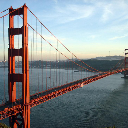

In [50]:
image_size = 128
images_path = "E:/UdeC/S1 2018/ML/Style Transfer"
# Load a content image
content_image = Image.open(images_path+"/content_images/05.jpg").resize((image_size, image_size))
style_image = Image.open(images_path+"/style_images/09.jpg").resize((image_size, image_size))
content_image # Resize just to see it at a smaller size

In [51]:
# Transforming into numeric information
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)

red_mean = 103.939
green_mean = 116.779
blue_mean = 123.68

content_array[:,:,:,0] -= red_mean
content_array[:,:,:,1] -= green_mean
content_array[:,:,:,2] -= blue_mean
content_array = content_array[:,:,:,::-1]
style_array[:,:,:,0] -= red_mean
style_array[:,:,:,1] -= green_mean
style_array[:,:,:,2] -= blue_mean
style_array = style_array[:,:,:,::-1]

print(content_array.shape, style_array.shape)

(1, 128, 128, 3) (1, 128, 128, 3)


In [52]:
#Defining our loss functions
def content_loss(content, combination):
    return tf.reduce_sum(tf.square(content-combination))

def gram_matrix(x): # Hay que entenderla bien
    features = tf.keras.backend.batch_flatten(tf.keras.backend.permute_dimensions(x, (2, 0, 1)))
    gram = tf.matmul(features, tf.transpose(features))
    return gram
def style_loss(style, combination): # Tambien
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    return tf.reduce_sum(tf.square(S - C)) / (4. * (channels ** 2) * (image_size ** 4))
def total_variation_loss(x):
    a = tf.square(x[:, :image_size-1, :image_size-1, :] - x[:, 1:, :image_size-1, :])
    b = tf.square(x[:, :image_size-1, :image_size-1, :] - x[:, :image_size-1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [53]:
# Start creating the main graph
content_node = tf.constant(content_array, name = "content_image", dtype=tf.float32)
style_node = tf.constant(style_array, name = "style_image", dtype=tf.float32)
combination_image = tf.Variable(tf.random_uniform(shape=[1,image_size, image_size,3], minval = -1, maxval= 1), dtype=tf.float32)
input_ten = tf.concat([content_node, style_node, combination_image], axis = 0)

In [54]:
# Importing the VGG16 pre-trained net to use it on the content loss
vgg = tf.keras.applications.VGG16(include_top = False, weights = "imagenet", input_tensor = input_ten)

In [55]:
layers = dict([(layer.name, layer.output) for layer in vgg.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_2/Relu:0' shape=(3, 128, 128, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_2/Relu:0' shape=(3, 128, 128, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_2/MaxPool:0' shape=(3, 64, 64, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_2/Relu:0' shape=(3, 64, 64, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_2/Relu:0' shape=(3, 64, 64, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_2/MaxPool:0' shape=(3, 32, 32, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_2/Relu:0' shape=(3, 32, 32, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_2/Relu:0' shape=(3, 32, 32, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_2/Relu:0' shape=(3, 32, 32, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_2/MaxPool:0' shape=(3, 16, 16, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_2/Relu:0' shape=(3, 16, 16, 512) dtype=float

In [56]:
# Continue with the graph
content_weight = 0.025*20
style_weight = 5
total_variation_weight = 1

content_reference_layer = "block2_conv2"
style_reference_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

loss = tf.Variable(0, name = "total_loss", dtype=tf.float32)

content_feature_layer = layers[content_reference_layer]
loss = loss + content_weight * content_loss(content_feature_layer[0,:,:,:], content_feature_layer[2,:,:,:])

for layer in style_reference_layers:
    style_feature_layers = layers[layer]
    loss = loss + (style_loss(style_feature_layers[1,:,:,:], style_feature_layers[2,:,:,:]))*style_weight/len(style_reference_layers)

loss = loss + total_variation_weight * total_variation_loss(combination_image)

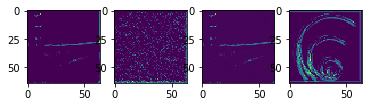

18214512.0


In [57]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    plt.subplot(1,4,1)
    plt.imshow(layers[content_reference_layer][0,:,:,40].eval())
    plt.subplot(1,4,2)
    plt.imshow(layers[content_reference_layer][2,:,:,40].eval())
    plt.subplot(1,4,3)
    plt.imshow(layers[content_reference_layer][0,:,:,40].eval()-layers[content_reference_layer][2,:,:,40].eval())
    plt.subplot(1,4,4)
    plt.imshow(layers[content_reference_layer][1,:,:,50].eval())
    plt.show()
    print(content_loss(layers[content_reference_layer][0,:,:,:].eval(), layers[content_reference_layer][2,:,:,:].eval()).eval())

In [58]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    style_feature_layers = layers["block1_conv2"]
    print(style_loss(style_feature_layers[1,:,:,:], style_feature_layers[2,:,:,:]).eval())

38302416.0


In [59]:

# Training
learning_rate = 1000

optimizer = tf.train.AdagradOptimizer(learning_rate)
gradients = optimizer.compute_gradients(loss, var_list=[combination_image])
train_step = optimizer.apply_gradients(gradients)
#train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, var_list=[combination_image])
n_iterations = 200
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    start_image = combination_image.eval()
    print(loss.eval())
    for i in range(n_iterations):
        #plt.figure(i)
        #plt.subplot(1,4,1)
        #plt.imshow(layers[content_reference_layer][0,:,:,40].eval())
        #plt.subplot(1,4,2)
        #plt.imshow(layers[content_reference_layer][2,:,:,40].eval())
        #plt.subplot(1,4,3)
        #plt.imshow(layers[content_reference_layer][0,:,:,40].eval()-layers[content_reference_layer][2,:,:,40].eval())
        #plt.subplot(1,4,4)
        #plt.imshow(layers[content_reference_layer][1,:,:,50].eval())
        #plt.show()
        sess.run(train_step)
        print("Error a la iteracion ", i, ": ", loss.eval())

    final_image = combination_image.eval()
    print(final_image)

36365824.0
Error a la iteracion  0 :  11092680000000.0
Error a la iteracion  1 :  525936230000.0
Error a la iteracion  2 :  105288450000.0
Error a la iteracion  3 :  73616550000.0
Error a la iteracion  4 :  24694055000.0
Error a la iteracion  5 :  9991924000.0
Error a la iteracion  6 :  6592792000.0
Error a la iteracion  7 :  5034019000.0
Error a la iteracion  8 :  4029404000.0
Error a la iteracion  9 :  3312430000.0
Error a la iteracion  10 :  2780358400.0
Error a la iteracion  11 :  2373852700.0
Error a la iteracion  12 :  2055503100.0
Error a la iteracion  13 :  1801198800.0
Error a la iteracion  14 :  1594592400.0
Error a la iteracion  15 :  1424272500.0
Error a la iteracion  16 :  1282060000.0
Error a la iteracion  17 :  1161973800.0
Error a la iteracion  18 :  1059551500.0
Error a la iteracion  19 :  971407300.0
Error a la iteracion  20 :  894939140.0
Error a la iteracion  21 :  828117700.0
Error a la iteracion  22 :  769339000.0
Error a la iteracion  23 :  717323970.0
Error a la

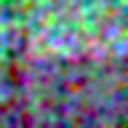

In [60]:
final_image = final_image.reshape((image_size, image_size, 3))
final_image = final_image[:,:,::-1]
final_image[:,:,0] += red_mean
final_image[:,:,1] += green_mean
final_image[:,:,2] += blue_mean
final_image = np.clip(final_image, 0, 255).astype("uint8")
Image.fromarray(final_image)

In [61]:
print(final_image)

[[[ 36 237  84]
  [ 31 233  79]
  [ 24 225  69]
  ...
  [137 255 134]
  [142 255 134]
  [143 255 132]]

 [[ 41 229  88]
  [ 37 226  82]
  [ 29 218  72]
  ...
  [139 255 137]
  [144 255 137]
  [146 255 136]]

 [[ 50 212  91]
  [ 46 210  85]
  [ 39 204  77]
  ...
  [139 247 142]
  [144 246 144]
  [147 247 144]]

 ...

 [[ 77 107  71]
  [ 80 106  72]
  [ 85 106  77]
  ...
  [ 50 104   1]
  [ 52 108   4]
  [ 52 109   4]]

 [[ 71 109  66]
  [ 76 107  66]
  [ 83 105  71]
  ...
  [ 57 108   0]
  [ 59 114   0]
  [ 61 117   0]]

 [[ 68 110  62]
  [ 74 107  62]
  [ 81 103  68]
  ...
  [ 59 109   0]
  [ 61 117   0]
  [  0   0 140]]]
